Pytorch implementation of AAE \
A. Makhzani, J. Shlens, N. Jaitly, I. Goodfellow, B. Frey, Adversarial Autoencoders, ICLR, 2018\
https://ai.google/research/pubs/pub44904

In [1]:
import time
import torch
from torch import nn, cuda, device, optim
import torchvision as tv
from torch.autograd import Variable
from torchsummary import summary

from matplotlib import pyplot as plt

print(cuda.is_available())
device = device('cuda:0')
print(device)

True
cuda:0


In [2]:
class Encoder(nn.Module):
    def __init__(self, nc, nf, nz):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, nf, 5, 2, 2, bias=False),
            nn.BatchNorm2d(nf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf, nf*2, 5, 2, 2, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf*2, nf*4, 5, 2, 2, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(in_features=4*4*nf*4, out_features=1024),
            nn.BatchNorm1d(num_features=1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.mu = nn.Linear(in_features=1024, out_features=nz)
        #self.var = nn.Linear(in_features=1024, out_features=nz)

    def forward(self, input):
        y =  self.net(input)
        return self.mu(y)#, self.var(y)

In [3]:
enc = Encoder(nc=3, nf=32, nz=128).to(device)
summary(enc, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           2,400
       BatchNorm2d-2           [-1, 32, 16, 16]              64
         LeakyReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          51,200
       BatchNorm2d-5             [-1, 64, 8, 8]             128
         LeakyReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]         204,800
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                 [-1, 1024]       2,098,176
      BatchNorm1d-12                 [-1, 1024]           2,048
        LeakyReLU-13                 [-1, 1024]               0
           Linear-14                  [

In [4]:
class Unflatten(nn.Module):
    def __init__(self, shape):
        super(Unflatten, self).__init__()
        self.shape = shape
        
    def forward(self, input):
        return input.view(len(input), self.shape[0], self.shape[1], self.shape[2])
    
class Decoder(nn.Module):
    def __init__(self, nc, nz, nf):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=nz, out_features=4*4*nf*4),
            nn.BatchNorm1d(num_features=4*4*nf*4),
            nn.LeakyReLU(0.2, inplace=True),
            Unflatten((128, 4, 4)),
            
            # add output_padding=1 to ConvTranspose2d to reconstruct original size
            nn.ConvTranspose2d(nf*4, nf*2, 5, 2, 2, 1, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(nf*2, nf, 5, 2, 2, 1, bias=False),
            nn.BatchNorm2d(nf),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(nf, int(nf/2), 5, 2, 2, 1, bias=False),
            nn.BatchNorm2d(int(nf/2)),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(int(nf/2), nc, 5, 1, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.net(input)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, nc, nz, nf):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(nz, 1000),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1000, 1),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.net(input)

In [6]:
dec = Decoder(nc=3, nz=128, nf=32).to(device)
dis = Discriminator(nc=3, nz=128, nf=32).to(device)

summary(dis, (1, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1000]         129,000
         LeakyReLU-2              [-1, 1, 1000]               0
            Linear-3              [-1, 1, 1000]       1,001,000
         LeakyReLU-4              [-1, 1, 1000]               0
            Linear-5                 [-1, 1, 1]           1,001
           Sigmoid-6                 [-1, 1, 1]               0
Total params: 1,131,001
Trainable params: 1,131,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 4.31
Estimated Total Size (MB): 4.35
----------------------------------------------------------------


In [7]:
batch_size = 128
image_size = 32
dataroot = '/raid/artem/tmp/celeba'
transform = tv.transforms.Compose([tv.transforms.Resize(image_size),
                                tv.transforms.CenterCrop(image_size),
                                tv.transforms.ToTensor(),
                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = tv.datasets.ImageFolder(root=dataroot, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=8, drop_last=True)
print(len(dataloader))

1582


In [8]:
nz = 128
enc = Encoder(nc=3, nf=32, nz=nz).to(device)
dec = Decoder(nc=3, nz=nz, nf=32).to(device)
dis = Discriminator(nc=3, nz=nz, nf=32).to(device)

In [9]:
beta = 0.5
optimizer_dis = optim.Adam(dis.parameters(), lr=1e-3, betas=(beta, 0.999))
optimizer_dec = optim.Adam(dec.parameters(), lr=1e-3, betas=(beta, 0.999))
optimizer_enc = optim.Adam(enc.parameters(), lr=1e-3, betas=(beta, 0.999))

In [10]:
criterion_gan = nn.BCELoss()
criterion_rec = nn.MSELoss(reduction='mean')
criterion_l1 = nn.L1Loss()

In [11]:
enc_losses = []
dec_losses = []
dis_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    start = time.time()
    for idx, (data, _) in enumerate(dataloader):
        #if idx == 1: break
        batch_size = data.shape[0]
        
        x = Variable(data).to(device)
        z = enc(x)
        
        #Dis
        z_real = Variable(torch.randn(batch_size, nz).to(device))
        y_real = Variable(torch.ones(batch_size).to(device))
        dis_real_loss = criterion_gan(dis(z_real).view(-1), y_real)
        
        y_fake = Variable(torch.zeros(batch_size).to(device))
        dis_fake_loss = criterion_gan(dis(z).view(-1), y_fake)
        
        dis.zero_grad()
        dis_loss = dis_fake_loss + dis_real_loss
        dis_loss.backward(retain_graph=True)
        optimizer_dis.step()
        dis_losses.append(dis_loss.item())
        
        #Enc 
        y_real = Variable(torch.ones(batch_size).to(device))
        enc_gan_loss = criterion_gan(dis(z).view(-1), y_real)
        
        enc_loss = enc_gan_loss
        
        enc.zero_grad()
        enc_loss.backward(retain_graph=True)
        optimizer_enc.step()
        enc_losses.append(enc_loss.item())
        
        #Dec
        rec = dec(z)
        dec_rec_loss = criterion_l1(x, rec)
        
        dec_loss = dec_rec_loss
        dec.zero_grad()
        dec_loss.backward()
        optimizer_dec.step()
        dec_losses.append(dec_loss.item())
        
        if not (idx % len(dataloader)):
            print('[%d/%d;%d/%d]: loss_dis: %.3f, loss_dec: %.3f, loss_enc: %.3f'
              % (idx, len(dataloader),
                 (epoch), epochs, 
                 torch.mean(torch.FloatTensor(dis_losses)), 
                 torch.mean(torch.FloatTensor(dec_losses)), 
                 torch.mean(torch.FloatTensor(enc_losses))))
    print('Time: ', time.time() - start)

[0/1582;1/100]: loss_dis: 1.386, loss_dec: 0.573, loss_enc: 0.573
Time:  288.7174081802368
[0/1582;2/100]: loss_dis: 1.208, loss_dec: 0.282, loss_enc: 2.533
Time:  252.55143785476685
[0/1582;3/100]: loss_dis: 1.262, loss_dec: 0.270, loss_enc: 2.028
Time:  228.93991446495056
[0/1582;4/100]: loss_dis: 1.288, loss_dec: 0.264, loss_enc: 1.794
Time:  229.24891424179077
[0/1582;5/100]: loss_dis: 1.302, loss_dec: 0.262, loss_enc: 1.648
Time:  234.62355518341064
[0/1582;6/100]: loss_dis: 1.310, loss_dec: 0.262, loss_enc: 1.569
Time:  228.96957755088806
[0/1582;7/100]: loss_dis: 1.312, loss_dec: 0.263, loss_enc: 1.528
Time:  230.35132670402527
[0/1582;8/100]: loss_dis: 1.311, loss_dec: 0.264, loss_enc: 1.505
Time:  229.85069966316223
[0/1582;9/100]: loss_dis: 1.309, loss_dec: 0.264, loss_enc: 1.486
Time:  230.85622572898865
[0/1582;10/100]: loss_dis: 1.307, loss_dec: 0.264, loss_enc: 1.470
Time:  229.7983593940735
[0/1582;11/100]: loss_dis: 1.306, loss_dec: 0.264, loss_enc: 1.449
Time:  229.226

Time:  117.149423122406
[0/1582;90/100]: loss_dis: 1.379, loss_dec: 0.264, loss_enc: 0.847
Time:  115.68963050842285
[0/1582;91/100]: loss_dis: 1.379, loss_dec: 0.264, loss_enc: 0.846
Time:  116.25182890892029
[0/1582;92/100]: loss_dis: 1.379, loss_dec: 0.264, loss_enc: 0.845
Time:  116.1229817867279
[0/1582;93/100]: loss_dis: 1.380, loss_dec: 0.265, loss_enc: 0.843
Time:  115.83854341506958
[0/1582;94/100]: loss_dis: 1.380, loss_dec: 0.265, loss_enc: 0.842
Time:  115.95704793930054
[0/1582;95/100]: loss_dis: 1.380, loss_dec: 0.265, loss_enc: 0.841
Time:  115.67856192588806
[0/1582;96/100]: loss_dis: 1.380, loss_dec: 0.266, loss_enc: 0.840
Time:  116.05498242378235
[0/1582;97/100]: loss_dis: 1.380, loss_dec: 0.266, loss_enc: 0.839
Time:  117.16152691841125
[0/1582;98/100]: loss_dis: 1.380, loss_dec: 0.266, loss_enc: 0.837
Time:  115.9534842967987
[0/1582;99/100]: loss_dis: 1.380, loss_dec: 0.266, loss_enc: 0.836
Time:  116.88275361061096
[0/1582;100/100]: loss_dis: 1.381, loss_dec: 0.2

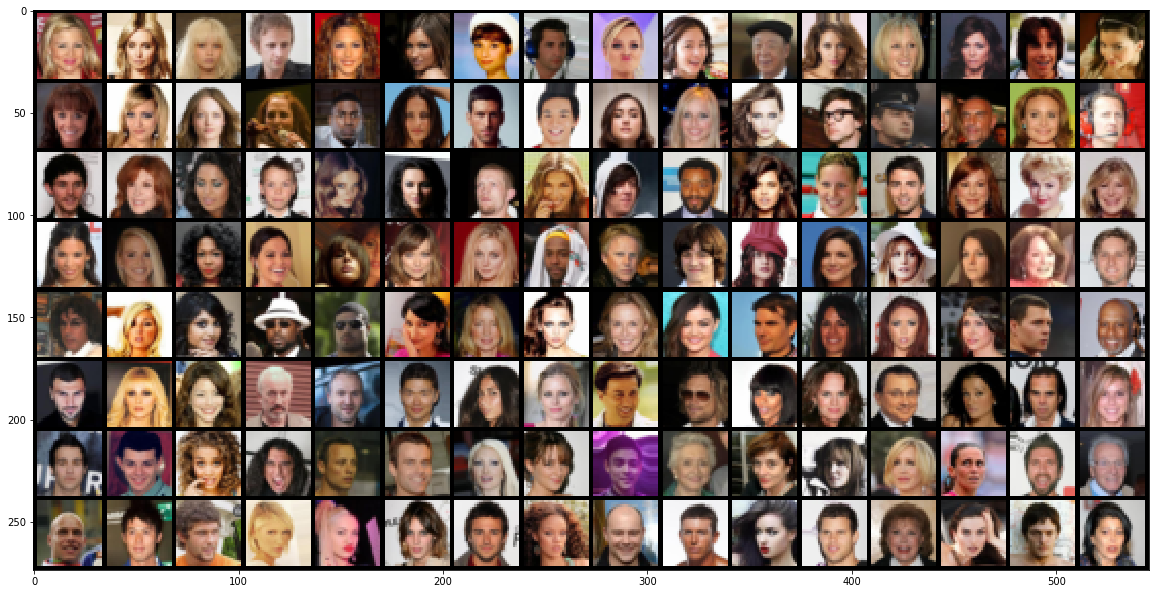

In [12]:
idx, (data, label) = next(enumerate(dataloader))
x = Variable(data).to(device)
plt.figure(figsize=(20,20))
plt.imshow(tv.utils.make_grid(x.detach().cpu(), nrow=16, normalize=True).permute(1, 2, 0))
plt.show()

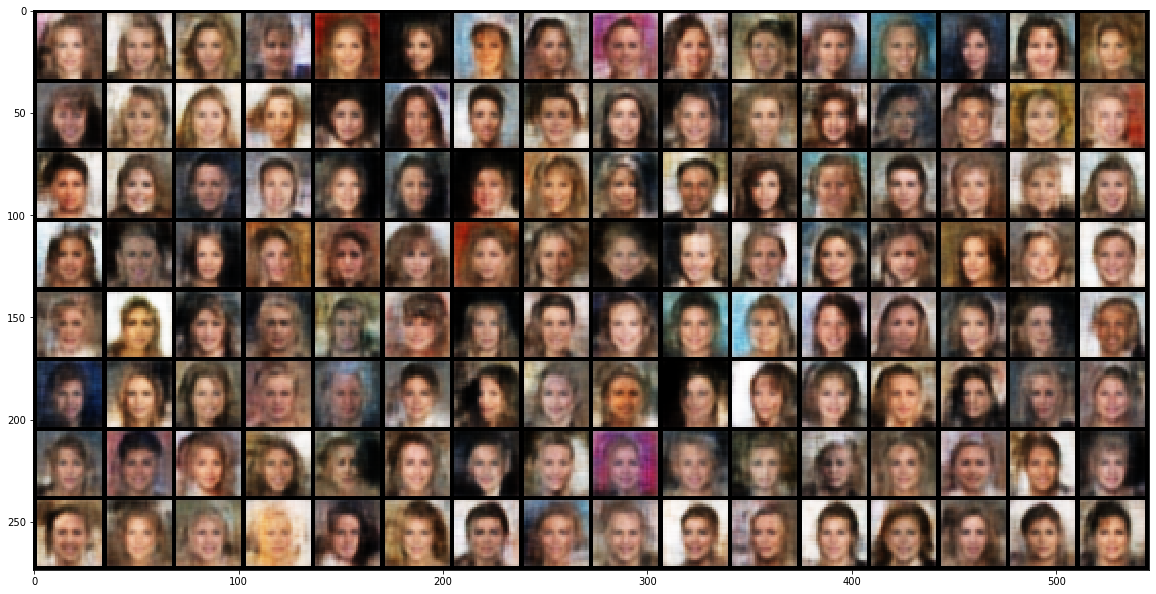

In [13]:
z = enc(x)
rec = dec(z)
y = rec.detach().cpu()
plt.figure(figsize=(20,20))
plt.imshow(tv.utils.make_grid(y,  nrow=16, normalize=True).permute(1, 2, 0))
plt.show()

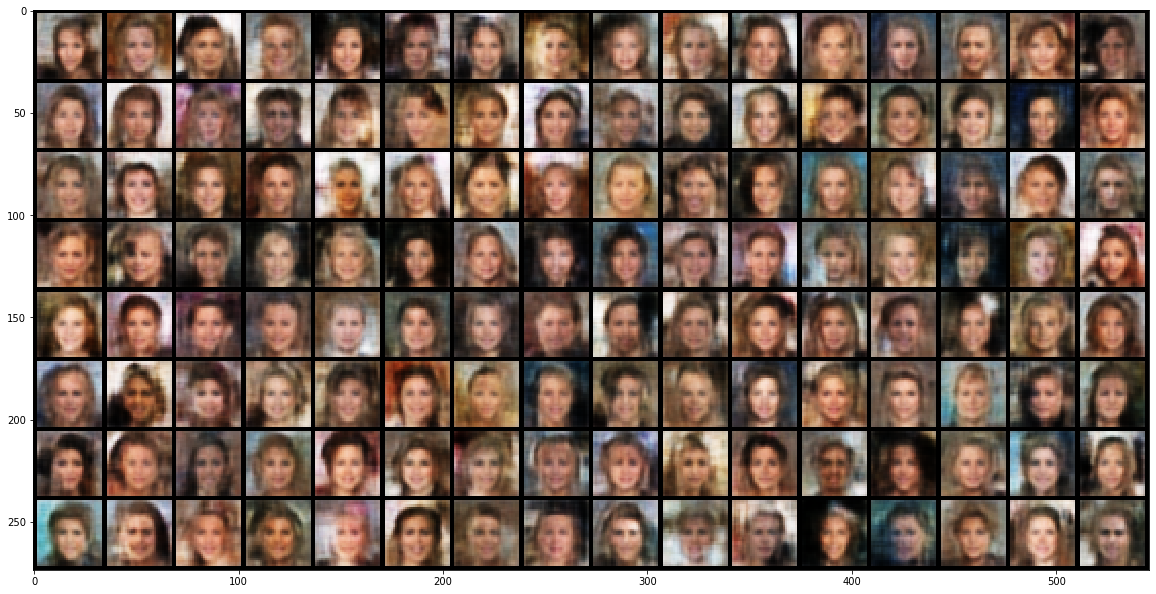

In [14]:
zp = Variable(torch.randn(batch_size, nz).to(device))
rec1 = dec(zp)
y1 = rec1.detach().cpu()
plt.figure(figsize=(20,20))
plt.imshow(tv.utils.make_grid(y1,  nrow=16, normalize=True).permute(1, 2, 0))
plt.show()